In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [5]:
# reading in full data set
# brfss_total = pd.read_csv("../csv_data/brfss_total.csv")
brfss_total = pd.read_csv("./brfss_total.csv")

In [6]:
brfss_total.head()

,Unnamed: 0,_STATE,DISPCODE,PHYSHLTH,MENTHLTH,USENOW3,HISPANC2,MARITAL,CHILDREN,EMPLOY,RENTHOM1,SEX,QLACTLM2,ACEDEPRS,ACEDRINK,ACEDRUGS,ACEPRISN,ACEDIVRC,ACEPUNCH,ACEHURT,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,MSCODE,_IMPAGE,_RFHLTH,_SMOKER3,_PRACE,_EDUCAG,_INCOMG,_TOTINDA
0,0,5.0,110.0,0.0,0.0,3.0,2.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,53.0,1.0,4.0,1.0,3.0,5.0,1.0
1,1,5.0,110.0,15.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,5.0,64.0,2.0,3.0,1.0,2.0,2.0,1.0
2,2,5.0,110.0,6.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,58.0,1.0,4.0,1.0,3.0,2.0,1.0
3,3,5.0,110.0,30.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,76.0,2.0,4.0,1.0,1.0,0.0,2.0
4,4,5.0,110.0,13.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,82.0,2.0,3.0,1.0,2.0,0.0,2.0


In [7]:
# just making sure no nulls are present
brfss_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117555 entries, 0 to 117554
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  117555 non-null  int64  
 1   _STATE      117555 non-null  float64
 2   DISPCODE    117555 non-null  float64
 3   PHYSHLTH    117555 non-null  float64
 4   MENTHLTH    117555 non-null  float64
 5   USENOW3     117555 non-null  float64
 6   HISPANC2    117555 non-null  float64
 7   MARITAL     117555 non-null  float64
 8   CHILDREN    117555 non-null  float64
 9   EMPLOY      117555 non-null  float64
 10  RENTHOM1    117555 non-null  float64
 11  SEX         117555 non-null  float64
 12  QLACTLM2    117555 non-null  float64
 13  ACEDEPRS    117555 non-null  float64
 14  ACEDRINK    117555 non-null  float64
 15  ACEDRUGS    117555 non-null  float64
 16  ACEPRISN    117555 non-null  float64
 17  ACEDIVRC    117555 non-null  float64
 18  ACEPUNCH    117555 non-null  float64
 19  AC

In [8]:
brfss_total.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
np.random.seed(151)

In [10]:
# creating X variable with all features
X_all = brfss_total.drop(columns=['USENOW3', 'QLACTLM2', '_RFHLTH', '_SMOKER3'])

In [11]:
# creating the 4 y's
y_tobacco = brfss_total['USENOW3']
y_activity = brfss_total['QLACTLM2']
y_health = brfss_total['_RFHLTH']
y_smoker = brfss_total['_SMOKER3']

In [12]:
#original baseline for tobacco
y_tobacco.value_counts(normalize=True)

3.0    0.966560
1.0    0.017872
2.0    0.012990
0.0    0.002578
Name: USENOW3, dtype: float64

In [13]:
#original baseline for activity
y_activity.value_counts(normalize=True)

2.0    0.724520
1.0    0.268997
0.0    0.006482
Name: QLACTLM2, dtype: float64

In [14]:
#original baseline for health
y_health.value_counts(normalize=True)

1.0    0.814742
2.0    0.181991
0.0    0.003267
Name: _RFHLTH, dtype: float64

In [15]:
#original baseline for smoker
y_smoker.value_counts(normalize=True)

4.0    0.521569
3.0    0.308324
1.0    0.119604
2.0    0.044226
0.0    0.006278
Name: _SMOKER3, dtype: float64

In [16]:
# splitting X up so I can do some engineering on the nominal data and ACE columns
X_num = X_all[['PHYSHLTH', 'MENTHLTH', 'CHILDREN']]
X_cat = X_all[['_STATE', 'DISPCODE', 'HISPANC2', 'MARITAL', 'EMPLOY', 'RENTHOM1', 'SEX', 'MSCODE', 
               '_IMPAGE', '_PRACE', '_EDUCAG', '_INCOMG','_TOTINDA']]
ace = X_all[['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT', 'ACESWEAR', 
                       'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']]

In [17]:
# updating ACE columns to be a count depending on the question
# first 5 questions are yes or no, so yes will be be counted as 1 and no will be counted as 0
# last 6 are questions of frequency, never = 0, once = 1, more than once = 2 (since not given an exact number)
ace['ACEDEPRS'] = ace['ACEDEPRS'].map({1:1, 2:0, 0:0})
ace['ACEDRINK'] = ace['ACEDRINK'].map({1:1, 2:0, 0:0})
ace['ACEDRUGS'] = ace['ACEDRUGS'].map({1:1, 2:0, 0:0})
ace['ACEPRISN'] = ace['ACEPRISN'].map({1:1, 2:0, 0:0})
ace['ACEDIVRC'] = ace['ACEDIVRC'].map({1:1, 2:0, 0:0})
ace['ACEPUNCH'] = ace['ACEPUNCH'].map({1:0, 2:1, 3:2, 0:0})
ace['ACEHURT'] = ace['ACEHURT'].map({1:0, 2:1, 3:2, 0:0})
ace['ACESWEAR'] = ace['ACESWEAR'].map({1:0, 2:1, 3:2, 0:0})
ace['ACETOUCH'] = ace['ACETOUCH'].map({1:0, 2:1, 3:2, 0:0})
ace['ACETTHEM'] = ace['ACETTHEM'].map({1:0, 2:1, 3:2, 0:0})
ace['ACEHVSEX'] = ace['ACEHVSEX'].map({1:0, 2:1, 3:2, 0:0})

In [18]:
# creating a column for counting the number of ACEs an individual had
X_num['ACE_Count'] = ace.sum(axis = 1)

In [19]:
# turning the nominal columns into strings so they can be dummified
X_cat = X_cat.astype(str)

In [20]:
# dummifying nominal variables for X_all
X_dummies = pd.get_dummies(X_cat, drop_first=True)
X_dummies.head()

,_STATE_15.0,_STATE_19.0,_STATE_22.0,_STATE_27.0,_STATE_30.0,_STATE_32.0,_STATE_37.0,_STATE_40.0,_STATE_47.0,_STATE_5.0,_STATE_50.0,_STATE_53.0,_STATE_55.0,DISPCODE_1100.0,DISPCODE_120.0,DISPCODE_1200.0,HISPANC2_1.0,HISPANC2_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,EMPLOY_1.0,EMPLOY_2.0,EMPLOY_3.0,EMPLOY_4.0,EMPLOY_5.0,EMPLOY_6.0,RENTHOM1_1.0,RENTHOM1_2.0,RENTHOM1_3.0,SEX_2.0,MSCODE_1.0,MSCODE_2.0,MSCODE_3.0,MSCODE_5.0,_IMPAGE_18.0,_IMPAGE_19.0,...,_IMPAGE_74.0,_IMPAGE_75.0,_IMPAGE_76.0,_IMPAGE_78.0,_IMPAGE_79.0,_IMPAGE_80.0,_IMPAGE_81.0,_IMPAGE_82.0,_IMPAGE_83.0,_IMPAGE_84.0,_IMPAGE_85.0,_IMPAGE_86.0,_IMPAGE_87.0,_IMPAGE_89.0,_IMPAGE_90.0,_IMPAGE_91.0,_IMPAGE_92.0,_IMPAGE_93.0,_IMPAGE_94.0,_IMPAGE_95.0,_IMPAGE_96.0,_IMPAGE_97.0,_IMPAGE_98.0,_PRACE_1.0,_PRACE_2.0,_PRACE_3.0,_PRACE_4.0,_PRACE_5.0,_PRACE_6.0,_EDUCAG_1.0,_EDUCAG_2.0,_EDUCAG_3.0,_EDUCAG_4.0,_INCOMG_1.0,_INCOMG_2.0,_INCOMG_3.0,_INCOMG_4.0,_INCOMG_5.0,_TOTINDA_1.0,_TOTINDA_2.0
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [21]:
X_num.head()

,PHYSHLTH,MENTHLTH,CHILDREN,ACE_Count
0,0.0,0.0,1.0,0
1,15.0,0.0,0.0,3
2,6.0,0.0,0.0,0
3,30.0,0.0,0.0,0
4,13.0,0.0,0.0,0


In [22]:
# merging numerical and nominal data into one data frame
X_all = X_num.merge(X_dummies, left_index=True, right_index=True)

In [23]:
X_all.shape

(117555, 138)

In [24]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X_all1, y_tobacco = sm.fit_resample(X_all, y_tobacco)

sm2 = SMOTE(random_state=151)
X_all2, y_activity = sm2.fit_resample(X_all, y_activity)

sm3 = SMOTE(random_state=151)
X_all3, y_health = sm3.fit_resample(X_all, y_health)

sm4 = SMOTE(random_state=151)
X_all4, y_smoker = sm4.fit_resample(X_all, y_smoker)

In [222]:
#y_tobacco.value_counts(normalize=True)

In [223]:
#y_activity.value_counts(normalize=True)

In [224]:
#y_health.value_counts(normalize=True)

In [225]:
#y_smoker.value_counts(normalize=True)

In [25]:
# looks like with SMOTE resampling, data set has increased about 4x
X_all1.shape

(454496, 138)

In [26]:
# creating training and testing sets for all y's
X_train_all, X_test_all, y_train_tobacco, y_test_tobacco = train_test_split(X_all1, y_tobacco, random_state = 151, stratify=y_tobacco)
X_train_all2, X_test_all2, y_train_activity, y_test_activity = train_test_split(X_all2, y_activity, random_state = 151, stratify=y_activity)
X_train_all3, X_test_all3, y_train_health, y_test_health = train_test_split(X_all3, y_health, random_state = 151, stratify=y_health)
X_train_all4, X_test_all4, y_train_smoker, y_test_smoker = train_test_split(X_all4, y_smoker, random_state = 151, stratify=y_smoker)

In [27]:
X_train_all.shape

(340872, 138)

In [28]:
y_train_tobacco.shape

(340872,)

In [29]:
pipe_all_tobacco = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300))
pipe_all_tobacco.fit(X_train_all, y_train_tobacco)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=F

In [30]:
pipe_all_activity = make_pipeline(SelectKBest(f_classif, k=136), StandardScaler(), ExtraTreesClassifier(max_depth=None, n_estimators=500))
pipe_all_activity.fit(X_train_all2, y_train_activity)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=136,
                             score_func=<function f_classif at 0x7fe906a76e18>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=500, n_jobs=None,
                                   

In [31]:
pipe_all_health = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), RandomForestClassifier(max_depth=None, n_estimators=100))
pipe_all_health.fit(X_train_all3, y_train_health)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fe906a76e18>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                

In [32]:
pipe_all_smoker = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), RandomForestClassifier(max_depth=None, n_estimators=500))
pipe_all_smoker.fit(X_train_all4, y_train_smoker)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fe906a76e18>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                

In [33]:
# getting predictions for each model
tobacco_all_preds = pipe_all_tobacco.predict(X_test_all)
activity_all_preds = pipe_all_activity.predict(X_test_all2)
health_all_preds = pipe_all_health.predict(X_test_all3)
smoker_all_preds = pipe_all_smoker.predict(X_test_all4)

# calculating the precision score for each model
tobacco_all_prec = precision_score(y_test_tobacco, tobacco_all_preds, average='micro')
activity_all_prec = precision_score(y_test_activity, activity_all_preds, average='micro')
health_all_prec = precision_score(y_test_health, health_all_preds, average='micro')
smoker_all_prec = precision_score(y_test_smoker, smoker_all_preds, average='micro')

In [34]:
print(f' training accuracy for tobacco w/ACE grouped: {pipe_all_tobacco.score(X_train_all, y_train_tobacco)}')
print(f' testing accuracy for tobacco w/ACE grouped: {pipe_all_tobacco.score(X_test_all, y_test_tobacco)}')
print(f'Precision for tobacco w/ACE grouped: {tobacco_all_prec}')

 training accuracy for tobacco w/ACE grouped: 0.9965441573376517
 testing accuracy for tobacco w/ACE grouped: 0.9920967401253257
Precision for tobacco w/ACE grouped: 0.9920967401253257


In [35]:
print(f' training accuracy for activity w/ACE grouped: {pipe_all_activity.score(X_train_all2, y_train_activity)}')
print(f' testing accuracy for activity w/ACE grouped: {pipe_all_activity.score(X_test_all2, y_test_activity)}')
print(f'Precision for activity w/ACE grouped: {activity_all_prec}')

 training accuracy for activity w/ACE grouped: 0.9990398363547178
 testing accuracy for activity w/ACE grouped: 0.9155591039308693
Precision for activity w/ACE grouped: 0.9155591039308693


In [36]:
print(f' training accuracy for health w/ACE grouped: {pipe_all_health.score(X_train_all3, y_train_health)}')
print(f' testing accuracy for health w/ACE grouped: {pipe_all_health.score(X_test_all3, y_test_health)}')
print(f'Precision for health w/ACE grouped: {health_all_prec}')

 training accuracy for health w/ACE grouped: 0.9987981326972872
 testing accuracy for health w/ACE grouped: 0.9453454540392299
Precision for health w/ACE grouped: 0.9453454540392299


In [37]:
print(f' training accuracy for smoker w/ACE grouped: {pipe_all_smoker.score(X_train_all4, y_train_smoker)}')
print(f' testing accuracy for smoker w/ACE grouped: {pipe_all_smoker.score(X_test_all4, y_test_smoker)}')
print(f'Precision for smoker w/ACE grouped: {smoker_all_prec}')

 training accuracy for smoker w/ACE grouped: 0.9935369667236422
 testing accuracy for smoker w/ACE grouped: 0.8006967459095535
Precision for smoker w/ACE grouped: 0.8006967459095535


In [38]:
# getting features importances for smokeless tobacco use
tobacco_all = pd.DataFrame({'features': X_all.columns.values, 'importance':pipe_all_tobacco.named_steps['randomforestclassifier'].feature_importances_})
tobacco_all = tobacco_all.sort_values('importance', ascending = False)

# looking at top 10
tobacco_all.head(10)

,features,importance
12,_STATE_47.0,0.105485
37,SEX_2.0,0.083121
3,ACE_Count,0.056033
17,DISPCODE_1100.0,0.049042
34,RENTHOM1_1.0,0.032145
28,EMPLOY_1.0,0.026223
38,MSCODE_1.0,0.022191
2,CHILDREN,0.020242
135,_INCOMG_5.0,0.019619
130,_EDUCAG_4.0,0.019582



*   State 47 = Tennessee
*   Sex 2 = Female
*   ACE_Count = # of **ACEs**
*   DISPCODE 1100 = completed interview
*   RENTHOM1 1 = Own home
*   EMPLOY 1 = employed for wages
*   MSCODE 1 = in the city center of a metropolitan statistical area (MSA)
*   Children = # of children in household
*   INCOMG 5 = income category of $50,000 or more
*   EDUCAG 4 = graduated from college or technical school












In [39]:
# looking at last 10
tobacco_all.tail(10)

,features,importance
107,_IMPAGE_84.0,4.134442e-04
111,_IMPAGE_89.0,3.427955e-04
109,_IMPAGE_86.0,2.584162e-04
114,_IMPAGE_92.0,1.442131e-04
115,_IMPAGE_93.0,1.324313e-04
117,_IMPAGE_95.0,4.619060e-05
116,_IMPAGE_94.0,2.273391e-06
120,_IMPAGE_98.0,1.983613e-06
118,_IMPAGE_96.0,1.174570e-06
119,_IMPAGE_97.0,8.927631e-07


**Looks like being an senior citizen has the least amount of influence on smokeless tobacco usage**

In [40]:
tobacco_all['importance'].sum()

0.9999999999999999

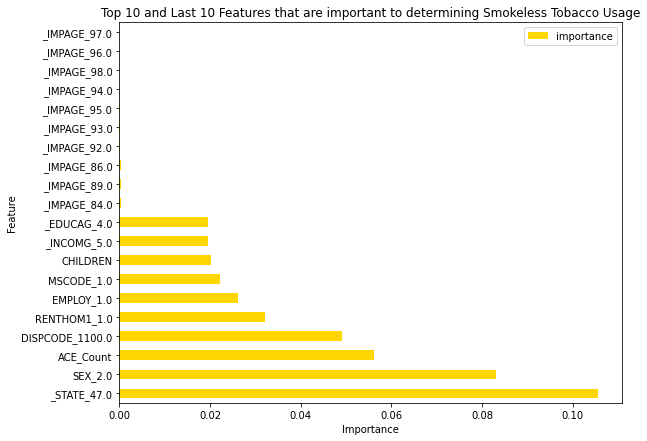

In [90]:
def top_bottom(df, color):
  ''' Function to graph Top 10 and Last 10 Features based on importance'''
  top_bottom = pd.merge(df.head(10), df.tail(10), how='outer')
  top_bottom.plot(kind='barh', figsize=(9, 7), color=color)
  plt.yticks(ticks=top_bottom.index, labels=top_bottom.features)
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.legend();
  return

top_bottom(tobacco_all, color = 'gold')
plt.title('Top 10 and Last 10 Features that are important to determining Smokeless Tobacco Usage');

plt.savefig('tobacco.jpg')

In [42]:
# getting features selected by 'selectkbest' for other three y's
features_activity_all = pipe_all_activity.named_steps['selectkbest'].get_support(indices=True) 
features_health_all = pipe_all_health.named_steps['selectkbest'].get_support(indices=True) 
features_smoker_all = pipe_all_smoker.named_steps['selectkbest'].get_support(indices=True) 

In [43]:
# getting column names for features selected by 'selectkbest' for other three y's
X_cols_activity_all = X_all.columns.values[features_activity_all]
X_cols_health_all = X_all.columns.values[features_health_all]
X_cols_smoker_all = X_all.columns.values[features_smoker_all]

In [44]:
# getting each feature's importance for other three y's
coefs_activity_all = pipe_all_activity.named_steps['extratreesclassifier'].feature_importances_
coefs_health_all = pipe_all_health.named_steps['randomforestclassifier'].feature_importances_
coefs_smoker_all = pipe_all_smoker.named_steps['randomforestclassifier'].feature_importances_

In [45]:
# feature importances for activity limitations
activity_all = pd.DataFrame({'features': X_cols_activity_all, 'importance':coefs_activity_all})
activity_all = activity_all.sort_values('importance', ascending = False)
activity_all.head(10)

,features,importance
0,PHYSHLTH,0.064875
12,_STATE_47.0,0.044570
28,EMPLOY_1.0,0.043460
3,ACE_Count,0.035963
34,RENTHOM1_1.0,0.032924
133,_INCOMG_5.0,0.029446
1,MENTHLTH,0.027759
37,SEX_2.0,0.024443
17,DISPCODE_1100.0,0.022504
22,MARITAL_1.0,0.020054



*   PHYSHLTH = # of days physical health not good (over a 30 day period)
*   State 47 = Tennessee
*   EMPLOY 1 = employed for wages
*   ACE_Count = # of ACEs
*   RENTHOM1 1 = Own home
*   INCOMG 5 = income category of $50,000 or more
*   MENTHLTH = # of days mental health not good (over a 30 day period)
*   Sex 2 = Female
*   MARITAL 1 = married

In [46]:
activity_all.tail(10)

,features,importance
47,_IMPAGE_23.0,0.000704
49,_IMPAGE_25.0,0.000692
42,_IMPAGE_18.0,0.000667
44,_IMPAGE_20.0,0.000644
43,_IMPAGE_19.0,0.000639
19,DISPCODE_1200.0,0.000567
116,_IMPAGE_95.0,0.000546
118,_IMPAGE_98.0,0.000274
115,_IMPAGE_94.0,0.000169
117,_IMPAGE_96.0,0.000088


**Looks like being very young or very old doesn't have much affect on activity limitations, nor does not finishing the survey in its entirety**

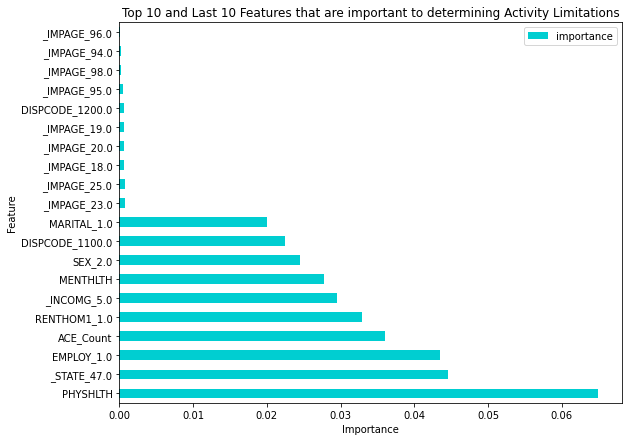

In [91]:
top_bottom(activity_all, color='darkturquoise')
plt.title('Top 10 and Last 10 Features that are important to determining Activity Limitations');

plt.savefig('activity.jpg')

In [48]:
# feature importances for self-reported health
health_all = pd.DataFrame({'features': X_cols_health_all, 'importance':coefs_health_all})
health_all = health_all.sort_values('importance', ascending = False)
health_all.head(10)

,features,importance
0,PHYSHLTH,0.097954
25,EMPLOY_1.0,0.047515
3,ACE_Count,0.041742
103,_INCOMG_5.0,0.038762
1,MENTHLTH,0.036171
99,_EDUCAG_4.0,0.029424
33,SEX_2.0,0.028227
30,RENTHOM1_1.0,0.027995
105,_TOTINDA_2.0,0.027984
104,_TOTINDA_1.0,0.025009


*   PHYSHLTH = # of days physical health not good (over a 30 day period)
*   EMPLOY 1 = employed for wages
*   ACE_Count = # of ACEs
*   INCOMG 5 = income category of $50,000 or more
*   EDUCAG 4 = graduated from college or technical school
*   MENTHLTH = # of days mental health not good (over a 30 day period)
*   Sex 2 = Female
*   RENTHOM1 1 = Own home
*   TOTINDA 2 = No physical activity or exercise in last 30 days 
*   TOTINDA 1 = had physical activity or exercise in last 30 days

In [49]:
health_all.tail(10)

,features,importance
93,_PRACE_4.0,0.000676
43,_IMPAGE_27.0,0.000651
86,_IMPAGE_90.0,0.000595
47,_IMPAGE_31.0,0.000566
39,_IMPAGE_21.0,0.000528
42,_IMPAGE_24.0,0.000487
46,_IMPAGE_30.0,0.000465
38,_IMPAGE_20.0,0.000324
40,_IMPAGE_22.0,0.000321
37,_IMPAGE_18.0,0.000303


**Looks like a few ages don't have a big influence on perceived health, nor does being Native Hawaiian or other Pacific Islander**

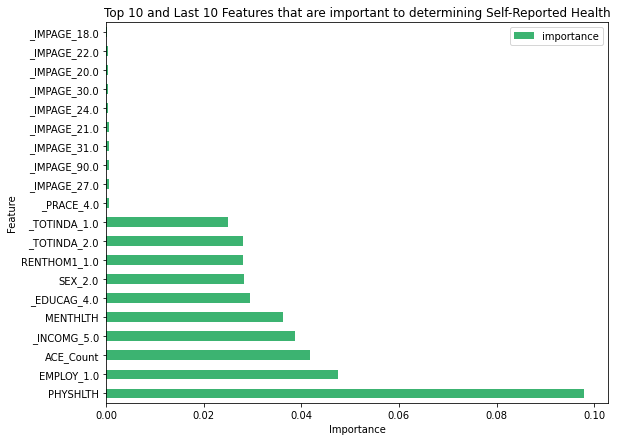

In [92]:
top_bottom(health_all, color = 'mediumseagreen')
plt.title('Top 10 and Last 10 Features that are important to determining Self-Reported Health');

plt.savefig('health.jpg')

In [51]:
# feature importances for smoker status
smoker_all = pd.DataFrame({'features': X_cols_smoker_all, 'importance':coefs_smoker_all})
smoker_all = smoker_all.sort_values('importance', ascending = False)
smoker_all.head(10)

,features,importance
3,ACE_Count,0.070039
0,PHYSHLTH,0.039284
1,MENTHLTH,0.036018
11,_STATE_47.0,0.035014
33,SEX_2.0,0.031330
2,CHILDREN,0.028582
24,EMPLOY_1.0,0.027787
30,RENTHOM1_1.0,0.026616
36,MSCODE_5.0,0.023771
15,DISPCODE_1100.0,0.023718


*   ACE_Count = # of ACEs
*   PHYSHLTH = # of days physical health not good (over a 30 day period)
*   MENTHLTH = # of days mental health not good (over a 30 day period)
*   State 47 = Tennessee
*   Sex 2 = Female
*   Children = # of children in household
*   EMPLOY 1 = employed for wages
*   RENTHOM1 1 = Own home
*   MSCODE 5 = not in a metropolitan statistical area (MSA)
*   DISPCODE 1100 = completed interview

In [52]:
smoker_all.tail(10)

,features,importance
44,_IMPAGE_25.0,0.001402
86,_IMPAGE_87.0,0.001280
39,_IMPAGE_20.0,0.001140
40,_IMPAGE_21.0,0.001119
38,_IMPAGE_19.0,0.001086
85,_IMPAGE_86.0,0.001064
87,_IMPAGE_90.0,0.000975
37,_IMPAGE_18.0,0.000905
89,_IMPAGE_92.0,0.000902
88,_IMPAGE_91.0,0.000483


**Looks like a few ages don't have a big influence on smoker status**

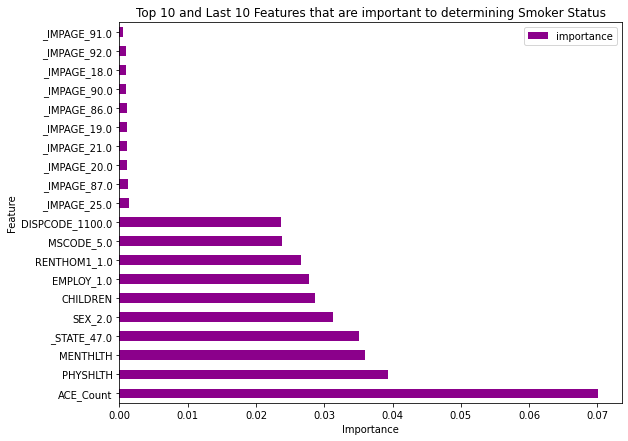

In [93]:
top_bottom(smoker_all, color='darkmagenta')
plt.title('Top 10 and Last 10 Features that are important to determining Smoker Status');

plt.savefig('smoker.jpg')

In [54]:
X_ace = X_num[['ACE_Count']]

In [55]:
X_ace.head()

,ACE_Count
0,0
1,3
2,0
3,0
4,0


In [56]:
# put in EDA notebook and create visualization(s)
X_ace.value_counts(normalize=True)

ACE_Count
0            0.430284
1            0.162409
2            0.113283
3            0.070818
4            0.053711
5            0.039803
6            0.031526
7            0.025511
8            0.020450
9            0.014359
10           0.010659
11           0.007860
12           0.005589
13           0.004475
14           0.003734
15           0.002986
16           0.001565
17           0.000978
dtype: float64

In [57]:
# creating the 4 y's for ACE count only
y_tobacco_ace = brfss_total['USENOW3']
y_activity_ace = brfss_total['QLACTLM2']
y_health_ace = brfss_total['_RFHLTH']
y_smoker_ace = brfss_total['_SMOKER3']

In [58]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X1, y_tobacco_ace = sm.fit_resample(X_ace, y_tobacco_ace)

sm2 = SMOTE(random_state=151)
X2, y_activity_ace = sm2.fit_resample(X_ace, y_activity_ace)

sm3 = SMOTE(random_state=151)
X3, y_health_ace = sm3.fit_resample(X_ace, y_health_ace)

sm4 = SMOTE(random_state=151)
X4, y_smoker_ace = sm4.fit_resample(X_ace, y_smoker_ace)

In [59]:
X1.shape

(454496, 1)

In [60]:
# creating training and testing sets for all ACE count y's 
X_train_ace, X_test_ace, y_train_tobacco_ace, y_test_tobacco_ace = train_test_split(X1, y_tobacco_ace, random_state = 151, stratify=y_tobacco_ace)
X_train_ace2, X_test_ace2, y_train_activity_ace, y_test_activity_ace = train_test_split(X2, y_activity_ace, random_state = 151, stratify=y_activity_ace)
X_train_ace3, X_test_ace3, y_train_health_ace, y_test_health_ace = train_test_split(X3, y_health_ace, random_state = 151, stratify=y_health_ace)
X_train_ace4, X_test_ace4, y_train_smoker_ace, y_test_smoker_ace = train_test_split(X4, y_smoker_ace, random_state = 151, stratify=y_smoker_ace)

In [61]:
ace_tobacco = xgb.XGBClassifier(learning_rate = 0.5, max_depth = 3, n_estimators = 20)
ace_tobacco.fit(X_train_ace, y_train_tobacco_ace)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [62]:
ace_activity = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 100)
ace_activity.fit(X_train_ace2, y_train_activity_ace)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
ace_health = ExtraTreesClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 500)
ace_health.fit(X_train_ace3, y_train_health_ace)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=500,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [64]:
ace_smoker = ExtraTreesClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300)
ace_smoker.fit(X_train_ace4, y_train_smoker_ace)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [65]:
tobacco_ace_preds = ace_tobacco.predict(X_test_ace)
activity_ace_preds = ace_activity.predict(X_test_ace2)
health_ace_preds = ace_health.predict(X_test_ace3)
smoker_ace_preds = ace_smoker.predict(X_test_ace4)

tobacco_ace_prec = precision_score(y_test_tobacco_ace, tobacco_ace_preds, average='micro')
activity_ace_prec = precision_score(y_test_activity_ace, activity_ace_preds, average='micro')
health_ace_prec = precision_score(y_test_health_ace, health_ace_preds, average='micro')
smoker_ace_prec = precision_score(y_test_smoker_ace, smoker_ace_preds, average='micro')

In [67]:
print(f' training accuracy for tobacco: {ace_tobacco.score(X_train_ace, y_train_tobacco_ace)}')
print(f' testing accuracy for tobacco: {ace_tobacco.score(X_test_ace, y_test_tobacco_ace)}')
print(f'Precision for tobacco: {tobacco_ace_prec}')

 training accuracy for tobacco: 0.38935729540707364
 testing accuracy for tobacco: 0.3859131873547842
Precision for tobacco: 0.3859131873547842


In [68]:
print(f' training accuracy for activity: {ace_activity.score(X_train_ace2, y_train_activity_ace)}')
print(f' testing accuracy for activity: {ace_activity.score(X_test_ace2, y_test_activity_ace)}')
print(f'Precision for activity: {activity_ace_prec}')

 training accuracy for activity: 0.4146498011835061
 testing accuracy for activity: 0.417148045523568
Precision for activity: 0.417148045523568


In [69]:
print(f' training accuracy for health: {ace_health.score(X_train_ace3, y_train_health_ace)}')
print(f' testing accuracy for health: {ace_health.score(X_test_ace3, y_test_health_ace)}')
print(f'Precision for health: {health_ace_prec}')

 training accuracy for health: 0.3728155249700693
 testing accuracy for health: 0.3759692620383389
Precision for health: 0.3759692620383389


In [70]:
print(f' training accuracy for smoker: {ace_smoker.score(X_train_ace4, y_train_smoker_ace)}')
print(f' testing accuracy for smoker: {ace_smoker.score(X_test_ace4, y_test_smoker_ace)}')
print(f'Precision for smoker: {smoker_ace_prec}')

 training accuracy for smoker: 0.2730131391813781
 testing accuracy for smoker: 0.27195271522141906
Precision for smoker: 0.27195271522141906




---




**Since we're only looking at one feature, the amount of ACEs someone had, to predict the y's, I believe logistic regression to be the best course of action when modeling. It is simple and easy to understand, something that is an asset when talking about such a sensitive topic. Also, the accuracy and precision for each y is comprable to those for the ensemble models above, differing the most for smokeless tobacco usage.**

---



In [71]:
ace_tobacco_lr = LogisticRegression(C=0.01)
ace_tobacco_lr.fit(X_train_ace, y_train_tobacco_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
ace_activity_lr = LogisticRegression(C=0.01)
ace_activity_lr.fit(X_train_ace2, y_train_activity_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
ace_health_lr = LogisticRegression(C=0.01)
ace_health_lr.fit(X_train_ace3, y_train_health_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
ace_smoker_lr = LogisticRegression(C=0.01)
ace_smoker_lr.fit(X_train_ace4, y_train_smoker_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
tobacco_ace_preds_lr = ace_tobacco_lr.predict(X_test_ace)
activity_ace_preds_lr = ace_activity_lr.predict(X_test_ace2)
health_ace_preds_lr = ace_health_lr.predict(X_test_ace3)
smoker_ace_preds_lr = ace_smoker_lr.predict(X_test_ace4)

tobacco_ace_prec_lr = precision_score(y_test_tobacco_ace, tobacco_ace_preds_lr, average='micro')
activity_ace_prec_lr = precision_score(y_test_activity_ace, activity_ace_preds_lr, average='micro')
health_ace_prec_lr = precision_score(y_test_health_ace, health_ace_preds_lr, average='micro')
smoker_ace_prec_lr = precision_score(y_test_smoker_ace, smoker_ace_preds_lr, average='micro')

In [77]:
print(f'Logistic Regression training accuracy for smokeless tobacco usage w/ACE grouped: {ace_tobacco_lr.score(X_train_ace, y_train_tobacco_ace)}')
print(f'Logistic Regression testing accuracy for smokeless tobacco usage w/ACE grouped: {ace_tobacco_lr.score(X_test_ace, y_test_tobacco_ace)}')
print(f'Logistic Regression precision for smokeless tobacco usage w/ACE grouped: {tobacco_ace_prec_lr}')

Logistic Regression training accuracy for smokeless tobacco usage w/ACE grouped: 0.37374146307118217
Logistic Regression testing accuracy for smokeless tobacco usage w/ACE grouped: 0.3732046046609871
Logistic Regression precision for smokeless tobacco usage w/ACE grouped: 0.3732046046609871


In [78]:
print(f'Logistic Regression training accuracy for activity limitations w/ACE grouped: {ace_activity_lr.score(X_train_ace2, y_train_activity_ace)}')
print(f'Logistic Regression testing accuracy for activity limitations w/ACE grouped: {ace_activity_lr.score(X_test_ace2, y_test_activity_ace)}')
print(f'Logistic Regression precision for activity limitations w/ACE grouped: {activity_ace_prec_lr}')

Logistic Regression training accuracy for activity limitations w/ACE grouped: 0.39769038897064196
Logistic Regression testing accuracy for activity limitations w/ACE grouped: 0.4002880445842922
Logistic Regression precision for activity limitations w/ACE grouped: 0.4002880445842922


In [79]:
print(f'Logistic Regression training accuracy for self-reported health w/ACE grouped: {ace_health_lr.score(X_train_ace3, y_train_health_ace)}')
print(f'Logistic Regression testing accuracy for self-reported health w/ACE grouped: {ace_health_lr.score(X_test_ace3, y_test_health_ace)}')
print(f'Logistic Regression precision for self-reported health w/ACE grouped: {health_ace_prec_lr}')

Logistic Regression training accuracy for self-reported health w/ACE grouped: 0.3632562715199213
Logistic Regression testing accuracy for self-reported health w/ACE grouped: 0.3658764077791544
Logistic Regression precision for self-reported health w/ACE grouped: 0.3658764077791544


In [80]:
print(f'Logistic Regression training accuracy for smoker status w/ACE grouped: {ace_smoker_lr.score(X_train_ace4, y_train_smoker_ace)}')
print(f'Logistic Regression testing accuracy for smoker status w/ACE grouped: {ace_smoker_lr.score(X_test_ace4, y_test_smoker_ace)}')
print(f'Logistic Regression precision for smoker w/ACE grouped: {smoker_ace_prec_lr}')

Logistic Regression training accuracy for smoker status w/ACE grouped: 0.2615223357384864
Logistic Regression testing accuracy for smoker status w/ACE grouped: 0.26244095926515487
Logistic Regression precision for smoker w/ACE grouped: 0.26244095926515487


In [81]:
# getting the coefficient for each tobacco class
coef_dk_tobacco = ace_tobacco_lr.coef_[0]
coef_everyday_tobacco = ace_tobacco_lr.coef_[1]
coef_somedays_tobacco = ace_tobacco_lr.coef_[2]
coef_notatall = ace_tobacco_lr.coef_[3]

# converting the log odds for each tobacco class into regular odds for interpretation
odds_dk_tobacco = np.exp(coef_dk_tobacco)
odds_everyday_tobacco = np.exp(coef_everyday_tobacco)
odds_somedays_tobacco = np.exp(coef_somedays_tobacco)
odds_notatall = np.exp(coef_notatall)

# putting converted odds into a dataframe
tobacco_coefs = pd.DataFrame([odds_dk_tobacco, odds_everyday_tobacco, odds_somedays_tobacco, odds_notatall], 
             index=['do not know', 'every day', 'some days', 'not at all'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
tobacco_coefs

,coef
some days,1.239700
every day,1.211356
not at all,1.192229
do not know,0.558537


In [82]:
# getting the coefficient for each smoker class
coef_dk_activity = ace_activity_lr.coef_[0]
coef_yes_activity = ace_activity_lr.coef_[1]
coef_no_activity = ace_activity_lr.coef_[2]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk_activity = np.exp(coef_dk_activity)
odds_yes_activity = np.exp(coef_yes_activity)
odds_no_activity = np.exp(coef_no_activity)

# putting converted odds into a dataframe
activity_coefs = pd.DataFrame([odds_dk_activity, odds_yes_activity, odds_no_activity], 
             index=['do not know', 'yes', 'no'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
activity_coefs

,coef
yes,1.079552
no,0.977599
do not know,0.947536


In [83]:
# getting the coefficient for each smoker class
coef_dk_health = ace_health_lr.coef_[0]
coef_good_better_health = ace_health_lr.coef_[1]
coef_fair_poor_health = ace_health_lr.coef_[2]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk_health = np.exp(coef_dk_health)
odds_good_better_health = np.exp(coef_good_better_health)
odds_fair_poor_health = np.exp(coef_fair_poor_health)

# putting converted odds into a dataframe
health_coefs = pd.DataFrame([odds_dk_health, odds_good_better_health, odds_fair_poor_health], 
             index=['do not know', 'Good or Better', 'Fair or Poor'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
health_coefs

,coef
Fair or Poor,1.053366
do not know,0.975238
Good or Better,0.973443


In [84]:
# got information about converting odds from https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

# getting the coefficient for each smoker class
coef_dk = ace_smoker_lr.coef_[0]
coef_everyday = ace_smoker_lr.coef_[1]
coef_somedays = ace_smoker_lr.coef_[2]
coef_former = ace_smoker_lr.coef_[3]
coef_never = ace_smoker_lr.coef_[4]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk = np.exp(coef_dk)
odds_everyday = np.exp(coef_everyday)
odds_somedays = np.exp(coef_somedays)
odds_former = np.exp(coef_former)
odds_never = np.exp(coef_never)

# putting converted odds into a dataframe
smoker_coefs = pd.DataFrame([odds_dk, odds_everyday, odds_somedays, odds_former, odds_never], 
             index=['do not know', 'every day', 'some days', 'former', 'never'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
smoker_coefs

,coef
every day,1.117938
some days,1.087797
former,1.012040
never,0.946684
do not know,0.858285


In [85]:
def coef_interpret(data):

  '''Function to interpret multiclass logistic regression coefficients. 
  Coefficient interpretation guidance came from http://www.columbia.edu/~so33/SusDev/Lecture_10.pdf

  data: a dataframe that only includes y classes, as an index, on only coefficients for each class

  '''
  for response, row in zip(data.index, data['coef']):
    if row > 1:
      print(f'For every one-unit increase in the number of ACEs someone has, the odds that a person is in the {response} class INCREASES by {(row - 1)*100}% when all other variables are held constant.')
    else:
      print(f'For every one-unit increase in the number of ACEs someone has, the odds that a person is in the {response} class DECREASES by {(1-row)*100}% when all other variables are held constant.')
  return

In [86]:
print(f'Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?')
coef_interpret(tobacco_coefs)

Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the some days class INCREASES by 23.96998826360548% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the every day class INCREASES by 21.13557934535446% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the not at all class INCREASES by 19.222936781581957% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 44.14630569630712% when all other variables are held constant.


In [87]:
print(f'Are you limited in any way in any activities because of physical, mental, or emotional problems?')
coef_interpret(activity_coefs)

Are you limited in any way in any activities because of physical, mental, or emotional problems?
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the yes class INCREASES by 7.95519333174215% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the no class DECREASES by 2.2401451724557764% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 5.246357826538361% when all other variables are held constant.


In [88]:
print(f'Adults with good or better health vs. fair or poor health')
coef_interpret(health_coefs)

Adults with good or better health vs. fair or poor health
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the Fair or Poor class INCREASES by 5.336561180571686% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 2.4762373158712214% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the Good or Better class DECREASES by 2.655725040518031% when all other variables are held constant.


In [89]:
print(f'Four-level smoker status: Every day smokers, Some days smokers, Former smokers, Non-smokers')
coef_interpret(smoker_coefs)

Four-level smoker status: Every day smokers, Some days smokers, Former smokers, Non-smokers
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the every day class INCREASES by 11.793819939463312% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the some days class INCREASES by 8.779749711025286% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the former class INCREASES by 1.203966667524825% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the never class DECREASES by 5.331606902778551% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 14.171483039763288% when all other 